<h1><center>Capstone Group 4 - Diabetes Readmission (Data Cleaning, Feature Engineering and EDA)</center></h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import re
%matplotlib inline

### Loading raw dataset for EDA Analysis

In [2]:
df = pd.read_csv('diabetic_data.csv')
df.replace('?',np.nan,inplace=True)

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


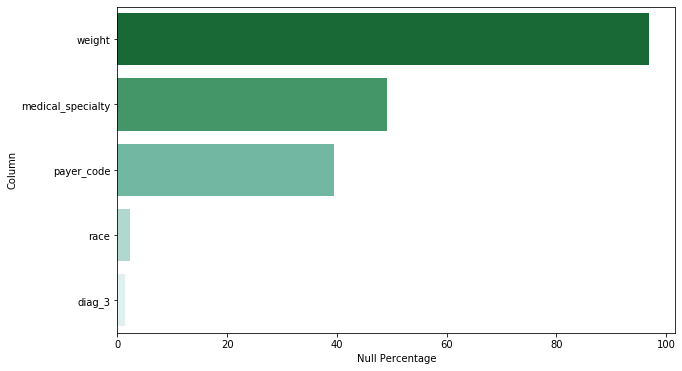

In [6]:
plt.figure(figsize=(10,6))
missing = pd.DataFrame({'column':df.columns ,'nullpct':df.isnull().sum()/len(df)*100})
missing.sort_values('nullpct',inplace=True, ascending = False)
sns.barplot(y=missing['column'][:5],x=missing['nullpct'], palette='BuGn_r')
plt.xlabel('Null Percentage')
plt.ylabel('Column')
plt.show()

## Data Cleaning

In [7]:
# Dropping the encounter as it is irrelevant to us
df.drop('encounter_id',axis=1,inplace=True)

In [8]:
print('Column'.ljust(27," "),'Null Percentage\n')
for col in list(df.columns):
    if ((df[col].isnull().sum()*100)/df.shape[0]).round(2) > 0:
        print(col.ljust(27,' '),((df[col].isnull().sum()*100)/df.shape[0]).round(2))

Column                      Null Percentage

race                        2.23
weight                      96.86
payer_code                  39.56
medical_specialty           49.08
diag_1                      0.02
diag_2                      0.35
diag_3                      1.4


In [9]:
# Dropping Weight and Payer Code columns as there are too many null values, and are of little signficance
df.drop('weight',axis=1,inplace=True)
df.drop('payer_code',axis=1,inplace=True)
df.drop('medical_specialty',axis=1,inplace=True)

In [10]:
df['race'].fillna(df['race'].mode()[0], inplace=True)
df['diag_1'].fillna(df['diag_1'].mode()[0], inplace=True)
df['diag_2'].fillna(df['diag_2'].mode()[0], inplace=True)
df['diag_3'].fillna(df['diag_3'].mode()[0], inplace=True)

In [11]:
#Filtering out all the values that resulted in hospice or death, as they are not relevant to this analysis.

df = df[df['discharge_disposition_id']!=11]
df = df[df['discharge_disposition_id']!=13]
df = df[df['discharge_disposition_id']!=14]
df = df[df['discharge_disposition_id']!=19]
df = df[df['discharge_disposition_id']!=20]
df = df[df['discharge_disposition_id']!=21]

In [12]:
df = df[df['gender']!='Unknown/Invalid']

In [13]:
Q1 = df.drop('patient_nbr',axis=1).quantile(0.25)
Q3 = df.drop('patient_nbr',axis=1).quantile(0.75)
IQR = Q3 - Q1
print(IQR)

admission_type_id            2.0
discharge_disposition_id     2.0
admission_source_id          6.0
time_in_hospital             4.0
num_lab_procedures          26.0
num_procedures               2.0
num_medications             10.0
number_outpatient            0.0
number_emergency             0.0
number_inpatient             1.0
number_diagnoses             3.0
dtype: float64


In [14]:
df.shape

(99340, 46)

In [15]:
# CONVERT DISCHARGE AND ADMISSION ID TO STR

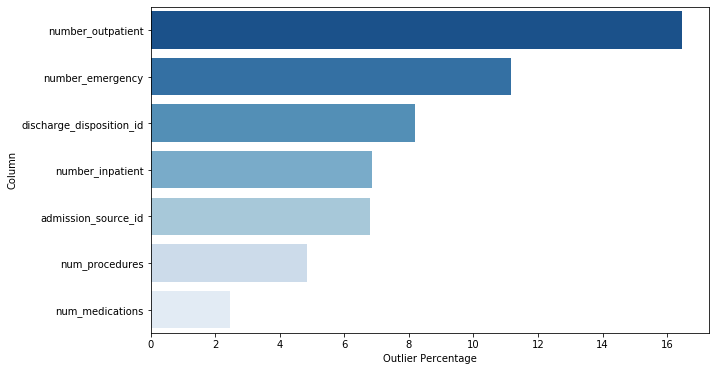

In [16]:
plt.figure(figsize=(10,6))
outliers = list(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()*100/99340)
outlierscol = list(df.columns)
outlierscol.sort()

outl = pd.DataFrame(data = {'Feature':outlierscol, 'Outliers %':outliers})
outl.sort_values('Outliers %',inplace=True, ascending = False)

sns.barplot(y=outl['Feature'][:7],x=outl['Outliers %'], palette='Blues_r')
plt.xlabel('Outlier Percentage')
plt.ylabel('Column')
plt.show()

In [17]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(56389, 46)

In [18]:
# Keep only first value for each patient
df.drop_duplicates(subset='patient_nbr',keep='first',inplace=True)
df.drop('patient_nbr',axis=1,inplace=True)

In [19]:
df.shape

(45919, 45)

## Feature Engineering

In [20]:
#Gender

df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)

In [21]:
#Change

df['change'] = df['change'].replace('No',0)
df['change'] = df['change'].replace('Ch',1)

In [22]:
# Diabetes Medication

df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

In [23]:
# Age

df['age'] = df['age'].replace('[0-10)',0)
df['age'] = df['age'].replace('[10-20)',0)
df['age'] = df['age'].replace('[20-30)',0)
df['age'] = df['age'].replace('[30-40)',0)
df['age'] = df['age'].replace('[40-50)',1)
df['age'] = df['age'].replace('[50-60)',1)
df['age'] = df['age'].replace('[60-70)',1)
df['age'] = df['age'].replace('[70-80)',2)
df['age'] = df['age'].replace('[80-90)',2)
df['age'] = df['age'].replace('[90-100)',2)

In [24]:
# Readmitted

df['readmitted'] = df['readmitted'].replace('NO', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('>30', 0)

In [25]:
# A1C Test
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)

In [26]:
# Glucose Serum Test
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)

In [27]:
df['total_patient_interaction'] = df['number_inpatient'] + df['number_emergency'] + df['number_outpatient']

df.drop('number_inpatient',axis=1,inplace=True)
df.drop('number_outpatient',axis=1,inplace=True)
df.drop('number_emergency',axis=1,inplace=True)

In [28]:
meds = list(df.columns[16:39])
for col in meds:
    df[col] = df[col].replace('No',0)
    df[col] = df[col].replace('Steady',0)
    df[col] = df[col].replace('Up',1)
    df[col] = df[col].replace('Down',1)

In [29]:
# Condense 19 columns into 1 by adding all changes
df['numchange'] = 0
for col in meds:
    colname = str(col) + 'temp'
    df[colname] = df[col]

for col in meds:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
    
df['numchange'].value_counts()

0    35341
1     9960
2      569
3       46
4        3
Name: numchange, dtype: int64

In [30]:
for col in meds:
    df.drop(col,axis=1,inplace=True)

In [31]:
df['race'] = df['race'].replace('Caucasian',0)
df['race'] = df['race'].replace('AfricanAmerican',1)
df['race'] = df['race'].replace('Other',2)
df['race'] = df['race'].replace('Hispanic',2)
df['race'] = df['race'].replace('Asian',2)

In [32]:
def diagnosis(feature):
    for k in df[feature]:
        if re.search('^[1-9]',k):
            if float(k)<=139.9:
                df[feature] = df[feature].replace(k,'Infectious and Parasitic Disease')
            elif float(k)<=239.9:
                df[feature] = df[feature].replace(k,'Neoplasms')
            elif float(k)<=279.9:
                df[feature] = df[feature].replace(k,'Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders')
            elif float(k)<=289.9:
                df[feature] = df[feature].replace(k,'Diseases of Blood and Blood Forming Organs')
            elif float(k)<=319:
                df[feature] = df[feature].replace(k,'Mental Disorders')
            elif float(k)<=389.9:
                df[feature] = df[feature].replace(k,'Diseases of Nervous System and Sense Organs')
            elif float(k)<=459.9:
                df[feature] = df[feature].replace(k,'Diseases of circulatory system')
            elif float(k)<=519.9:
                df[feature] = df[feature].replace(k,'Diseases of respiratory system')
            elif float(k)<=579.9:
                df[feature] = df[feature].replace(k,'Diseases of the Digestive System')
            elif float(k)<=629.9:
                df[feature] = df[feature].replace(k,'Diseases of the Genitourinary System')
            elif float(k)<=676.9:
                df[feature] = df[feature].replace(k,'Complications of Pregnancy, Childbirth and the Puerperium')
            elif float(k)<=709.9:
                df[feature] = df[feature].replace(k,'Diseases of the Skin and Subcutaneous Tissue')	
            elif float(k)<=739.9:
                df[feature] = df[feature].replace(k,'Diseases of the Musculoskeletal System and Connective Tissue')
            elif float(k)<=759.9:
                df[feature] = df[feature].replace(k,'Congenital Anomalies')
            elif float(k)<=779.9:
                df[feature] = df[feature].replace(k,'Certain Conditions Originating in the Perinatal Period')
            elif float(k)<=799.9:
                df[feature] = df[feature].replace(k,'Symptoms, Signs and Ill-defined Conditions')
            elif float(k)<=999.9:
                df[feature] = df[feature].replace(k,'Injury and Poisoning')
        elif re.search('^V',k):
            df[feature] = df[feature].replace(k, 'Supplementary Factors Influencing Health Status and Contact with Health Services')
        
        elif re.search('^E.*[0-9]$',k):
            df[feature] = df[feature].replace(k, 'Supplementary Classification Of External Causes Of Injury And Poisoning ')

In [33]:
diagnosis('diag_1')
diagnosis('diag_2')
diagnosis('diag_3')

In [34]:
import category_encoders as ce 
encoder = ce.BackwardDifferenceEncoder(cols=['diag_1', 'diag_2','diag_3'])
df = encoder.fit_transform(df)
df = df.drop('intercept',axis = 1)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,diag_3_15,diag_3_16,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,total_patient_interaction,numchange
1,0,0,0,1,1,7,3,59,0,18,...,-0.111111,-0.055556,9,-99,-99,1,1,0,0,1
3,0,1,0,1,1,7,2,44,1,16,...,-0.111111,-0.055556,7,-99,-99,1,1,0,0,1
4,0,1,1,1,1,7,1,51,0,8,...,-0.111111,-0.055556,5,-99,-99,1,1,0,0,0
6,0,1,1,3,1,2,4,70,1,21,...,-0.111111,-0.055556,7,-99,-99,1,1,0,0,0
7,0,1,2,1,1,7,5,73,0,12,...,-0.111111,-0.055556,8,-99,-99,0,1,0,0,0


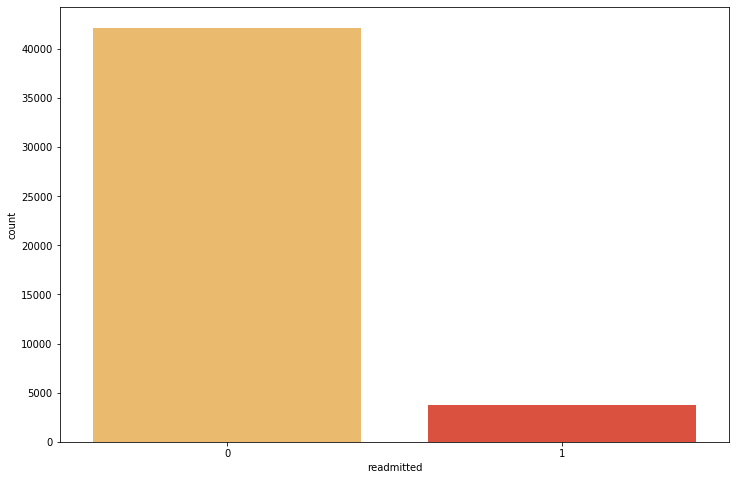

In [35]:
plt.figure(figsize=(12,8))
sns.countplot(df['readmitted'],palette='YlOrRd')
plt.show()

In [51]:
df['readmitted'].value_counts()

0    42176
1     3743
Name: readmitted, dtype: int64

### Bivariate Analysis

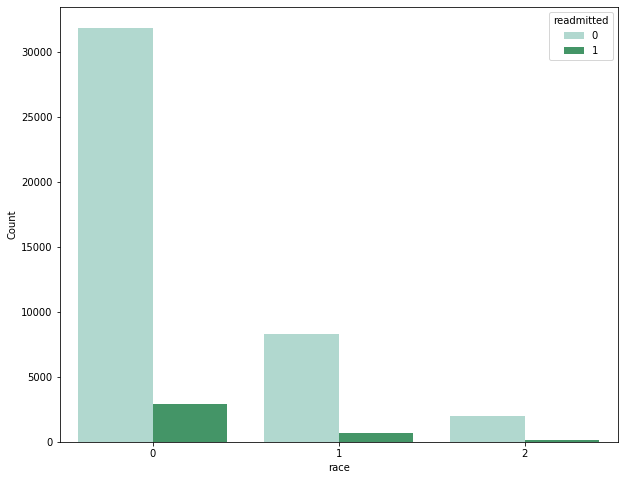

In [36]:
plt.figure(figsize=(10,8))
sns.countplot(df['race'],hue=df['readmitted'], palette='BuGn')
plt.ylabel('Count')
plt.show()

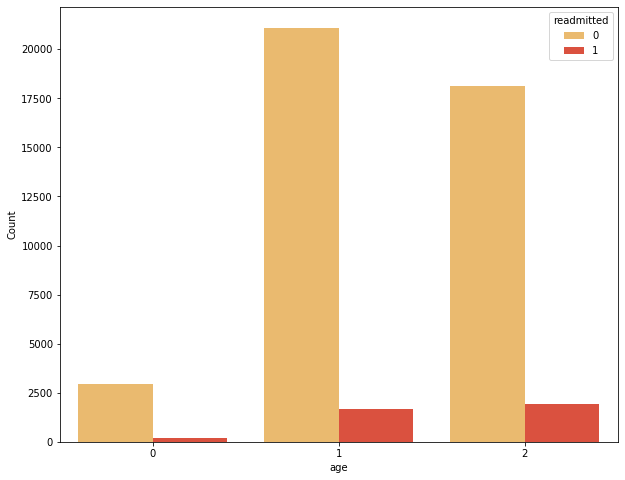

In [37]:
plt.figure(figsize=(10,8))
sns.countplot(df['age'],hue=df['readmitted'], palette='YlOrRd')
plt.ylabel('Count')
plt.show()

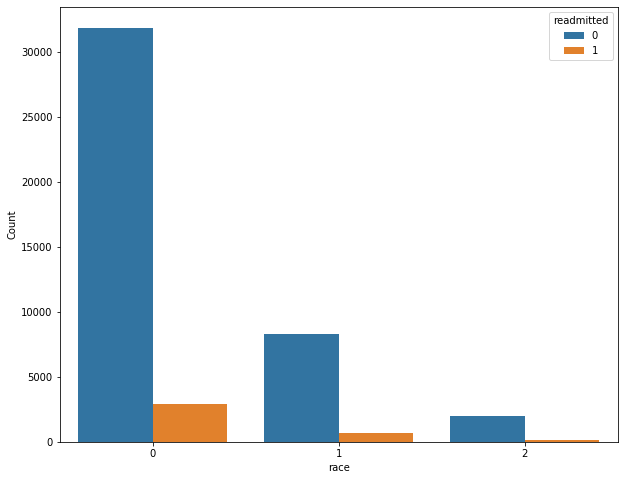

In [38]:
plt.figure(figsize=(10,8))
sns.countplot(df['race'],hue=df['readmitted'])
plt.ylabel('Count')
plt.show()

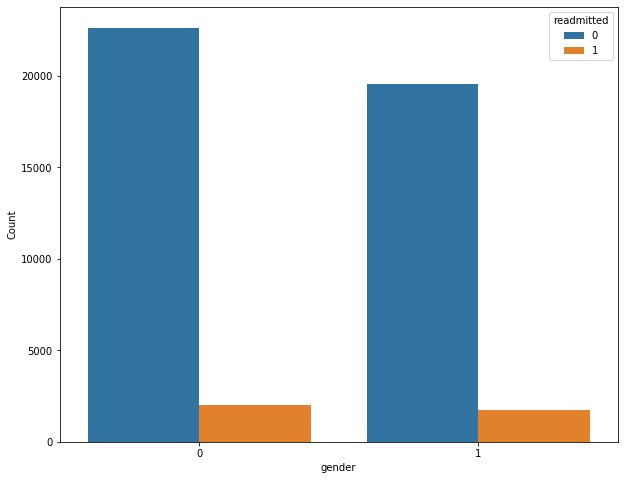

In [39]:
plt.figure(figsize=(10,8))
sns.countplot(df['gender'],hue=df['readmitted'])
plt.ylabel('Count')
plt.show()

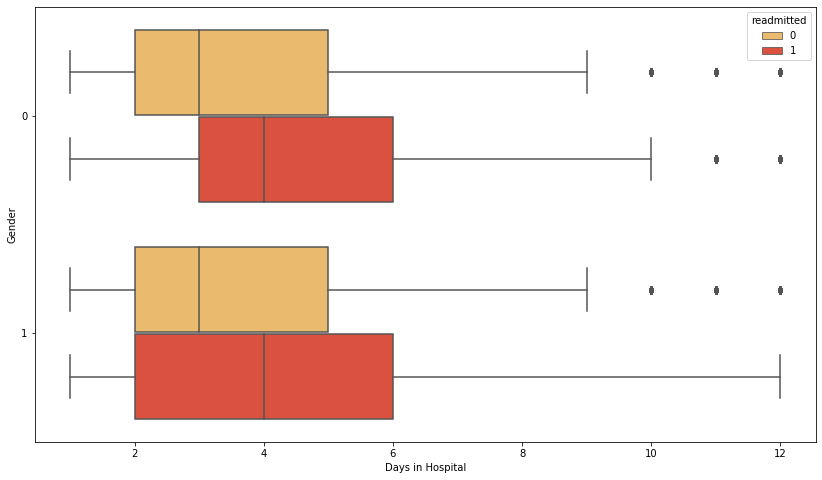

In [40]:
plt.figure(figsize=(14, 8))
sns.boxplot(y=df['gender'], x=df['time_in_hospital'], hue=df['readmitted'], orient='h', palette = 'YlOrRd')
plt.xlabel('Days in Hospital')
plt.ylabel('Gender')
plt.show()

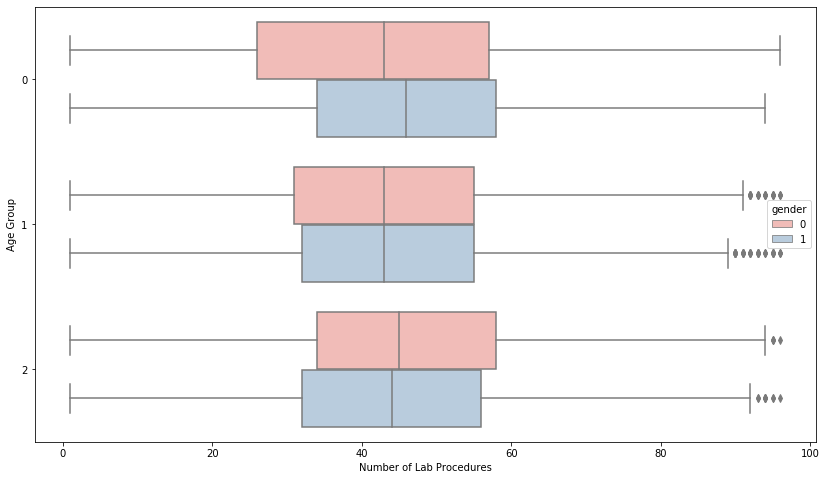

In [41]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x=df['num_lab_procedures'], hue = df['gender'], orient='h', palette = 'Pastel1')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Age Group')
plt.show()

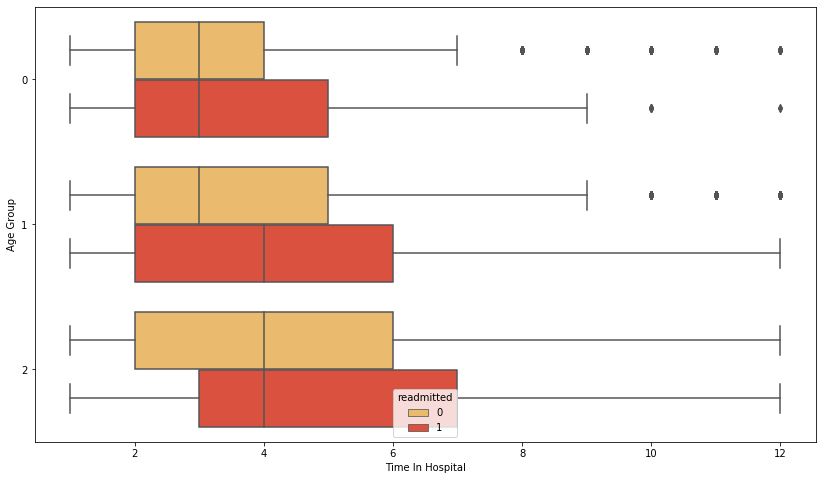

In [42]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x = df['time_in_hospital'], hue = df['readmitted'],orient='h', palette='YlOrRd')
plt.xlabel('Time In Hospital')
plt.ylabel('Age Group')
plt.show()

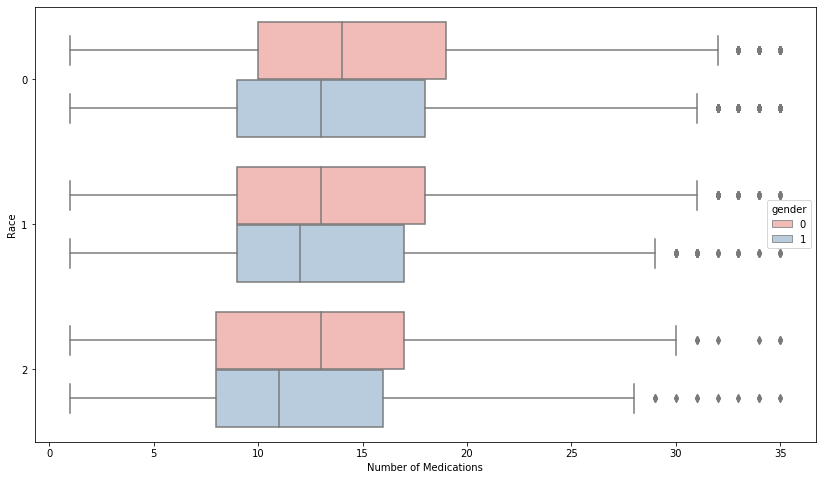

In [43]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['race'],x = df['num_medications'], hue = df['gender'],orient='h', palette = 'Pastel1')
plt.xlabel('Number of Medications')
plt.ylabel('Race')
plt.show()

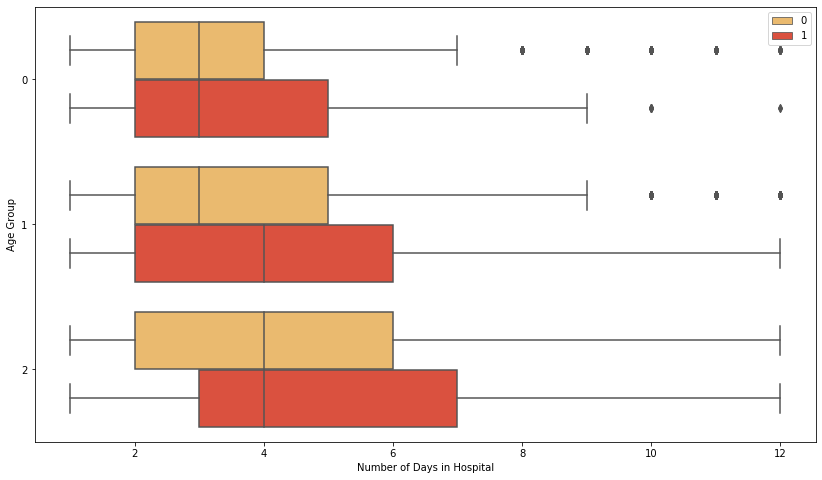

In [44]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x=df['time_in_hospital'], hue = df['readmitted'], orient='h',palette='YlOrRd')
plt.xlabel('Number of Days in Hospital')
plt.ylabel('Age Group')
plt.legend(loc='0')
plt.show()

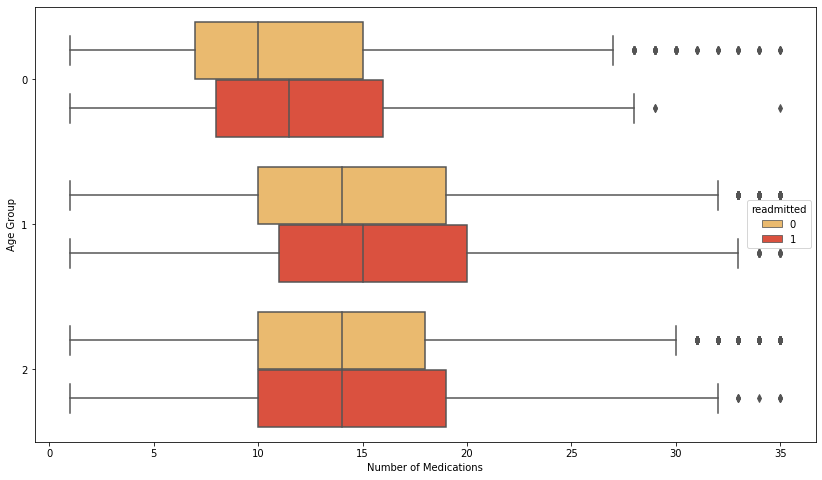

In [45]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x=df['num_medications'], hue = df['readmitted'], orient='h',palette='YlOrRd')
plt.xlabel('Number of Medications')
plt.ylabel('Age Group')
plt.show()

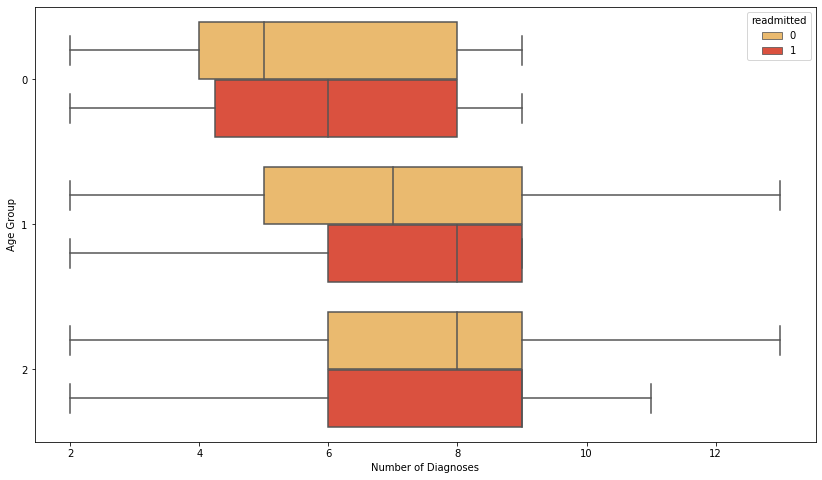

In [46]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x=df['number_diagnoses'], hue = df['readmitted'], orient='h',palette='YlOrRd')
plt.xlabel('Number of Diagnoses')
plt.ylabel('Age Group')
plt.show()

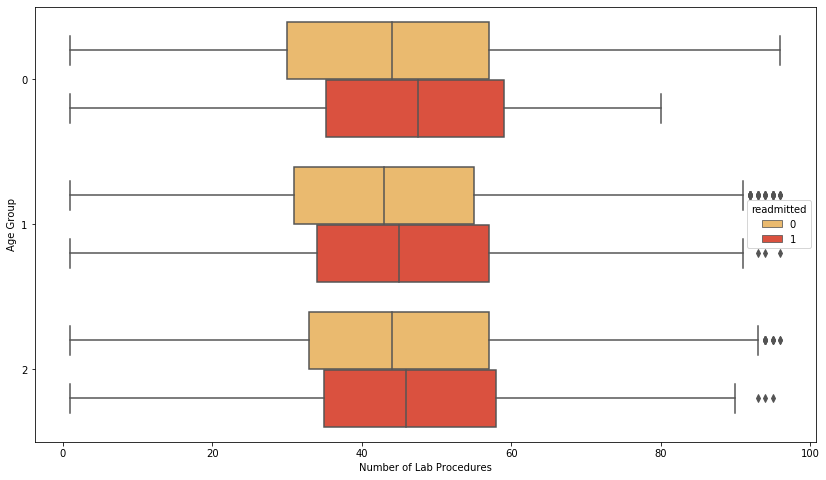

In [47]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x=df['num_lab_procedures'], hue = df['readmitted'], orient='h',palette='YlOrRd')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Age Group')
plt.show()

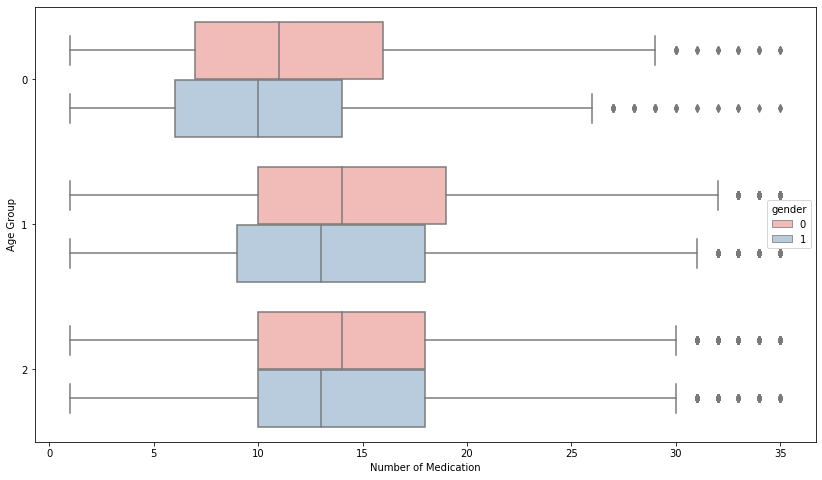

In [48]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['age'],x=df['num_medications'], hue = df['gender'], orient='h',palette='Pastel1')
plt.xlabel('Number of Medication')
plt.ylabel('Age Group')
plt.show()

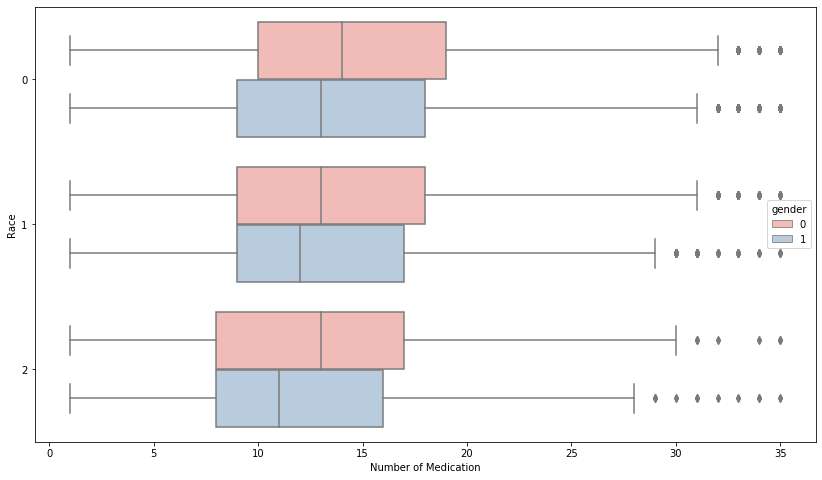

In [49]:
plt.figure(figsize=(14,8))
sns.boxplot(y=df['race'],x=df['num_medications'], hue = df['gender'], orient='h',palette='Pastel1')
plt.xlabel('Number of Medication')
plt.ylabel('Race')
plt.show()